Include the effect of skip in our approach and as a opinion

In [1]:
import numpy as np
import pandas as pd
import copy #Use for Deep copy
import math
from datetime import datetime

import seaborn as sns
import matplotlib.pyplot as plt

In [4]:
with open('D:\\decertation\\data\sentiment analysis dataset\\full_code\\response_matrix.npy', 'rb') as f:
    response_matrix = np.load(f)
print(response_matrix)

[[ 3 -1 -1 ... -1 -1 -1]
 [ 3 -1 -1 ... -1 -1 -1]
 [ 3 -1  1 ... -1 -1  2]
 ...
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]
 [-1 -1 -1 ... -1 -1 -1]]


In [5]:
train = pd.read_csv('D:\\decertation\\data\sentiment analysis dataset\\full_code\\new_gold.csv')
print(train.head())

   Unnamed: 0  original_question   ques  new_judgement
0           0           79185724  72701              1
1           1           79185900  72868              1
2           2           79186190  73151              2
3           3           79186569  73515              2
4           4           79186651  73592              0


In [6]:
judgement_counts = np.bincount(train['new_judgement'])
Negetive = judgement_counts[0]
Neutral = judgement_counts[1]
Positive = judgement_counts[2]
not_related = judgement_counts[3]
cant_tell = judgement_counts[4]

print(f'In gold data Positive : {Positive}, Neutral : {Neutral}, Negetive : {Negetive},\
        Not Related : {not_related}, Can not tell: {cant_tell}')

In gold data Positive : 190, Neutral : 250, Negetive : 228,        Not Related : 307, Can not tell: 25


In [7]:
c, r = len(np.unique(response_matrix))-1, response_matrix.shape[1]
p = r * c

In [8]:
Tot_ques = r
print(f"Total question {Tot_ques}")

Total question 98980


# Proposed approach for streaming data

Calculating initial accuracy of annotators

In [9]:
s1 = int(len(train)* 0.3)
train2 = train[ : s1]

accuracy = [1 / len(train2)]*response_matrix.shape[0]
for i in range (response_matrix.shape[0]):
    tot, corr = 0.0, 0.0
    for j in range(len(train2)):
        if -1 != response_matrix[i][train2[train2.columns[2]][j]]:
            tot += 1
            if train2[train2.columns[3]][j] == response_matrix[i][train2[train2.columns[2]][j]]:
                corr += 1
    if tot != 0:
        accuracy[i] += corr / tot
minacc = np.min(accuracy)
maxacc = np.max(accuracy)
accuracy = (accuracy - minacc)/ (maxacc-minacc)
print(accuracy[ : 5])

[0.         0.66666667 0.85714286 0.86363636 0.5       ]


Required function

In [10]:
vector_mapping = {
        0: np.array((1, 0, 0, 0)),
        1: np.array((1, 1, 0, 0)),
        2: np.array((-1, 0, 0, 0)),
        3: np.array((1, 1, 1, 0)),
        4: np.array((1, 1, 1, 1))
    }

def vectorised(a):
    return vector_mapping.get(a, np.array((0, 0, 0, 0)))

In [11]:
def dist(a,b):
    s = 0
    for j in range(len(a)):
        p, q = vectorised(a[j]), vectorised(b[j])
        s += math.dist(p, q)
    return s

In [12]:
# def difficulty(block, difficulty_list, total):
#     total += block.shape[0]
#     for j in range(block.shape[1]):
#         for i in range(block.shape[0]):
#             if block[i][j] == 4:  #block[i][j] == 4 means corresponding response is "I can't tell"
#                 difficulty_list[j] += 1
#     return difficulty_list, total

In [13]:
def difficulty(block, difficulty_list, total):
    total += block.shape[0]
    A = block.T
    for j in range(block.shape[1]):
        unique, counts = np.unique(A[j], return_counts=True)
        
        difficulty_list[j] += 0 if np.any(counts[np.where(unique == 4)])==False else counts[np.where(unique == 4)][0]
    return difficulty_list, total

In [14]:
# def local_directory(row):
#     local_dict = {}
#     local_dict['vector'] = row
#     local_dict['frequency'] = 1
    
#     unique, counts = np.unique(row, return_counts=True)
#     s = 0 if np.any(counts[np.where(unique == -1)]) == False else counts[np.where(unique == -1)][0]
#     local_dict['response_number'] = Tot_ques - s
    
#     return local_dict

In [15]:
def local_directory(row):
    local_dict = {
        'vector': row,
        'frequency': 1,
        'response_number': np.count_nonzero(row != -1)
    }
    return local_dict

In [16]:
#Cluster with distance = hyp
def cluster(cluster_dict, block, hyp):
    cluster_id = []
    distance, i = 0, len(cluster_dict)
    for j in range(len(block)):
        if not bool(cluster_dict):  #Check if cluster_dict is empty
            i += 1
            cluster_dict[i] = local_directory(block[j])
            cluster_id.append(i)
#             distance += 0

        else:
            l, k = 1, i
            while l <= k:
                d = dist(block[j], cluster_dict[l]['vector'])
                if d <= hyp:
                    cluster_dict[l]['frequency'] += 1
                    cluster_id.append(l)
                    distance += d

                    break
                else:
                    l += 1
                if l == k+1:
                    i += 1
                    cluster_dict[i] = local_directory(block[j])
                    cluster_id.append(i)
#                     distance += 0

    return cluster_dict, cluster_id, distance

In [17]:
#Clustering with finding the distance
def clustering(cluster_dict, block, d):
    # Use ELBOW Method to find the threshold of the distance
    distance_list = []
    
    for it in range (1,100):
        k = it * 100
        cluster_dictionary = copy.deepcopy(cluster_dict)
        _, _, distance = cluster(cluster_dictionary, block, k)
        distance_list.append(distance)


    ratio = [(distance_list[i] - distance_list[i-1]) * 0.001 for i in range(1, len(distance_list))]
    ratio1 = [a for a in ratio if a != 0]
    index = [i for i, a in enumerate(ratio) if a != 0]

    ind_ch = [(ratio1[i] - ratio1[i-1]) / (index[i] - index[i-1]) for i in range(1, len(index))]

    # dis = d    
    # for index in range(1, len(ind_ch)):
    #     if ind_ch[index] >= 1:
    #         a = ind_ch.index(ind_ch[index]) + 1
    #         dis = ratio.index(ratio1[a])*100
    #         break

    dis = d
    index = next((i for i, val in enumerate(ind_ch[1:], start=1) if val >= 1), None)
    if index is not None:
        a = ind_ch.index(ind_ch[index]) + 1
        dis = ratio.index(ratio1[a]) * 100
                

#     cluster_dict,cluster_id, _ = cluster(cluster_dict, block, dis)   
    return cluster_dict, dis

In [18]:
def judge(J, block, cluster_dict, a, dis, accuracy_list):    
    cluster_dict, cluster_id, _ = cluster(cluster_dict, block, dis)
    
    weight = []
    for k in range(block.shape[0]):
        w = accuracy_list[a + k] + const * cluster_dict[cluster_id[k]]['response_number']/cluster_dict[cluster_id[k]]['frequency']
        weight.append(w)
    
    for j in range(block.shape[1]):
        for k in range(block.shape[0]):
            if block[k][j] != -1:
                J[j][block[k][j]] += weight[k]

    return J, cluster_dict

Main function for Proposed approach

In [19]:
const = 1 / Tot_ques
dis = 1000
cluster_dict = {}
J = np.array([0.]*p).reshape(r, c)
Result = np.array([-1]*r)
difficulty_list = [0]*response_matrix.shape[1]
total = 0

In [20]:
# total = 10
# a = 0
# accuracy_list = [1, 2, 3, 4, 5]
# difficulty_list = [1]
# for j in range(3):
#     accuracy_list[a:a + 4] += difficulty_list[j] / total

In [21]:
a, b = 0, 50

time1 = datetime.now()
A = response_matrix[a : b]
_, dis = clustering(cluster_dict, A, dis)
time2 = datetime.now()
print(f"start time : {time1}  end time : {time2}  required time : {(time2 - time1)}")

while b <= response_matrix.shape[0]:
    
    time1 = datetime.now()
    A = response_matrix[a : b]
    
    #Update the accuracy of the annotators
    difficulty_list, total = difficulty(A, difficulty_list, total)
    
    accuracy_list = copy.deepcopy(accuracy)
    for i in range(A.shape[0]):
        for j in range(A.shape[1]):
            accuracy_list[a + i] +=  difficulty_list[j] / total 
#     for j in range(A.shape[1]):
#         accuracy_list[a:a + A.shape[0]] += difficulty_list[j] / total
        
    
    #Judgement
    J, cluster_dict = judge(J, A, cluster_dict, a, dis, accuracy_list)
    
    # Calculate final result
    # for j in range(J.shape[0]):
    #     Result[j] = np.argmax(J[j])
    Result = np.argmax(J, axis=1)
    
    #Calculate accuracy
    # right = 0
    # for j in range(len(train)):
    #     if train[train.columns[3]][j] == Result[train[train.columns[2]][j]]:
    #         right += 1
    right = np.sum(train[train.columns[3]].values == Result[train[train.columns[2]].values])
    
    time2 = datetime.now()
    print(f"start time : {time1}  end time : {time2}  required time : {(time2 - time1)}")
    print(f'Accuracy after {b} annotators\' response is {right / len(train) * 100 :.4f} %')
    
    
    a = b
    b += 50

start time : 2023-05-31 14:57:35.382442  end time : 2023-05-31 20:45:04.034061  required time : 5:47:28.651619
start time : 2023-05-31 20:45:04.047038  end time : 2023-05-31 20:59:12.355163  required time : 0:14:08.308125
Accuracy after 50 annotators' response is 55.1000 %
start time : 2023-05-31 20:59:12.355163  end time : 2023-05-31 21:35:44.715879  required time : 0:36:32.360716
Accuracy after 100 annotators' response is 71.7000 %
start time : 2023-05-31 21:35:44.715879  end time : 2023-05-31 22:31:52.721539  required time : 0:56:08.005660
Accuracy after 150 annotators' response is 77.5000 %
start time : 2023-05-31 22:31:52.723533  end time : 2023-06-01 00:26:00.819229  required time : 1:54:08.095696
Accuracy after 200 annotators' response is 81.4000 %
start time : 2023-06-01 00:26:00.819229  end time : 2023-06-01 01:55:31.031095  required time : 1:29:30.211866
Accuracy after 250 annotators' response is 84.0000 %
start time : 2023-06-01 01:55:31.031095  end time : 2023-06-01 03:22:3

Confusion matrix

In [22]:
Confusion_matrix = np.zeros((5, 5), dtype = 'int64')
for j in range(len(train)):
    if train[train.columns[3]][j] == 0:
        if train[train.columns[3]][j] == Result[train[train.columns[2]][j]]:
            Confusion_matrix[0][0] += 1
        elif Result[train[train.columns[2]][j]] == 1:
            Confusion_matrix[0][1] += 1
        elif Result[train[train.columns[2]][j]] == 2:
            Confusion_matrix[0][2] += 1
        elif Result[train[train.columns[2]][j]] == 3:
            Confusion_matrix[0][3] += 1
        elif Result[train[train.columns[2]][j]] == 4:
            Confusion_matrix[0][4] += 1
            
    if train[train.columns[3]][j] == 1:
        if train[train.columns[3]][j] == Result[train[train.columns[2]][j]]:
            Confusion_matrix[1][1] += 1
        elif Result[train[train.columns[2]][j]] == 0:
            Confusion_matrix[1][0] += 1
        elif Result[train[train.columns[2]][j]] == 2:
            Confusion_matrix[1][2] += 1
        elif Result[train[train.columns[2]][j]] == 3:
            Confusion_matrix[1][3] += 1
        elif Result[train[train.columns[2]][j]] == 4:
            Confusion_matrix[1][4] += 1
            
    if train[train.columns[3]][j] == 2:
        if train[train.columns[3]][j] == Result[train[train.columns[2]][j]]:
            Confusion_matrix[2][2] += 1
        elif Result[train[train.columns[2]][j]] == 0:
            Confusion_matrix[2][0] += 1
        elif Result[train[train.columns[2]][j]] == 1:
            Confusion_matrix[2][1] += 1
        elif Result[train[train.columns[2]][j]] == 3:
            Confusion_matrix[2][3] += 1
        elif Result[train[train.columns[2]][j]] == 4:
            Confusion_matrix[2][4] += 1
    
    if train[train.columns[3]][j] == 3:
        if train[train.columns[3]][j] == Result[train[train.columns[2]][j]]:
            Confusion_matrix[3][3] += 1
        elif Result[train[train.columns[2]][j]] == 0:
            Confusion_matrix[3][0] += 1
        elif Result[train[train.columns[2]][j]] == 1:
            Confusion_matrix[3][1] += 1
        elif Result[train[train.columns[2]][j]] == 2:
            Confusion_matrix[3][2] += 1
        elif Result[train[train.columns[2]][j]] == 4:
            Confusion_matrix[3][4] += 1
    
    if train[train.columns[3]][j] == 4:
        if train[train.columns[3]][j] == Result[train[train.columns[2]][j]]:
            Confusion_matrix[4][4] += 1
        elif Result[train[train.columns[2]][j]] == 0:
            Confusion_matrix[4][0] += 1
        elif Result[train[train.columns[2]][j]] == 1:
            Confusion_matrix[4][1] += 1
        elif Result[train[train.columns[2]][j]] == 2:
            Confusion_matrix[4][2] += 1
        elif Result[train[train.columns[2]][j]] == 3:
            Confusion_matrix[4][3] += 1
    
print(Confusion_matrix)

[[194  20   2   8   4]
 [  3 217   1  21   8]
 [  1  15 167   7   0]
 [  1   7   2 297   0]
 [  1   9   2   6   7]]


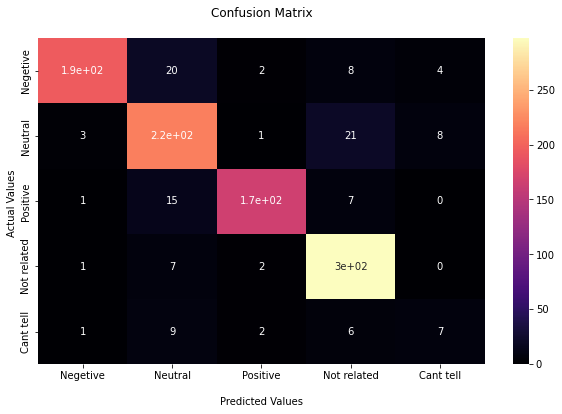

In [23]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(Confusion_matrix, annot=True, cmap = plt.cm.magma)

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(i for i in ('Negetive', 'Neutral', 'Positive', 'Not related', 'Cant tell'))
ax.yaxis.set_ticklabels(i for i in ('Negetive', 'Neutral', 'Positive', 'Not related', 'Cant tell'))
plt.show()

# Majority voting

In [24]:
def majority(J, block, a):
    for j in range(block.shape[1]):
        for k in range(block.shape[0]):
            if response_matrix[a + k][j] != -1:
                M[j][response_matrix[a + k][j]] += 1  
        
    return M

In [25]:
a, b = 0, 50

M = np.array([-1]*p).reshape(r, c)
Majority_Result = np.array([-1.]*r)

# while b <= response_matrix.shape[0]:
while b <= 550:
    A = response_matrix[a : b]
    M = majority(M, A, a)
    
    for j in range(M.shape[0]):
        Majority_Result[j] = np.argmax(M[j])
    
    right = 0
    for j in range(len(train)):
        if train[train.columns[3]][j] == Majority_Result[train[train.columns[2]][j]]:
            right += 1

    print(f'Accuracy after {b} annotators\' response is {right / len(train) * 100 :.4f} %')
    
    a = b
    b += 50

Accuracy after 50 annotators' response is 55.0000 %
Accuracy after 100 annotators' response is 71.8000 %
Accuracy after 150 annotators' response is 77.5000 %
Accuracy after 200 annotators' response is 81.3000 %
Accuracy after 250 annotators' response is 84.0000 %
Accuracy after 300 annotators' response is 85.2000 %
Accuracy after 350 annotators' response is 85.7000 %
Accuracy after 400 annotators' response is 86.3000 %
Accuracy after 450 annotators' response is 86.7000 %
Accuracy after 500 annotators' response is 87.4000 %
Accuracy after 550 annotators' response is 87.6000 %


Confusion matrix

In [26]:
Confusion_matrix = np.zeros((5, 5), dtype = 'int64')
for j in range(len(train)):
    if train[train.columns[3]][j] == 0:
        if train[train.columns[3]][j] == Majority_Result[train[train.columns[2]][j]]:
            Confusion_matrix[0][0] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 1:
            Confusion_matrix[0][1] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 2:
            Confusion_matrix[0][2] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 3:
            Confusion_matrix[0][3] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 4:
            Confusion_matrix[0][4] += 1
            
    if train[train.columns[3]][j] == 1:
        if train[train.columns[3]][j] == Majority_Result[train[train.columns[2]][j]]:
            Confusion_matrix[1][1] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 0:
            Confusion_matrix[1][0] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 2:
            Confusion_matrix[1][2] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 3:
            Confusion_matrix[1][3] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 4:
            Confusion_matrix[1][4] += 1
    
    if train[train.columns[3]][j] == 2:
        if train[train.columns[3]][j] == Majority_Result[train[train.columns[2]][j]]:
            Confusion_matrix[2][2] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 0:
            Confusion_matrix[2][0] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 1:
            Confusion_matrix[2][1] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 3:
            Confusion_matrix[2][3] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 4:
            Confusion_matrix[2][4] += 1
    
    if train[train.columns[3]][j] == 3:
        if train[train.columns[3]][j] == Majority_Result[train[train.columns[2]][j]]:
            Confusion_matrix[3][3] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 0:
            Confusion_matrix[3][0] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 1:
            Confusion_matrix[3][1] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 2:
            Confusion_matrix[3][2] += 0
        elif Majority_Result[train[train.columns[2]][j]] == 4:
            Confusion_matrix[3][4] += 1
    
    if train[train.columns[3]][j] == 4:
        if train[train.columns[3]][j] == Majority_Result[train[train.columns[2]][j]]:
            Confusion_matrix[4][4] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 0:
            Confusion_matrix[4][0] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 1:
            Confusion_matrix[4][1] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 2:
            Confusion_matrix[4][2] += 1
        elif Majority_Result[train[train.columns[2]][j]] == 3:
            Confusion_matrix[4][3] += 1
    
print(Confusion_matrix)

[[202  18   2   4   2]
 [  4 219   2  18   7]
 [  3  22 161   4   0]
 [  7  10   0 288   0]
 [  4   7   2   6   6]]


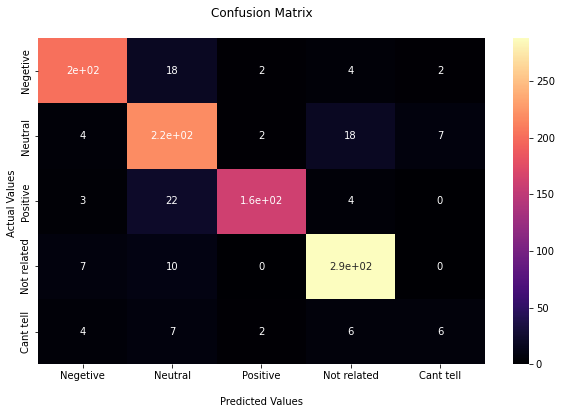

In [27]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(Confusion_matrix, annot=True, cmap = plt.cm.magma)

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(i for i in ('Negetive', 'Neutral', 'Positive', 'Not related', 'Cant tell'))
ax.yaxis.set_ticklabels(i for i in ('Negetive', 'Neutral', 'Positive', 'Not related', 'Cant tell'))
plt.show()

# Weighted Majority Voting

In [28]:
def weighted_majority(J, block, a):
    for j in range(block.shape[1]):
        for k in range(block.shape[0]):
            if response_matrix[a + k][j] != -1:
                M[j][response_matrix[a + k][j]] += accuracy[a + k]
        
    return M

In [29]:
a, b = 0, 50

M = np.array([-1]*p).reshape(r, c)
Weighted_Majority_Result = np.array([-1.]*r)

# while b <= response_matrix.shape[0]:
while b <= 550:
    A = response_matrix[a : b]
    M = weighted_majority(M, A, a)
    
    for j in range(M.shape[0]):
        Weighted_Majority_Result[j] = np.argmax(M[j])
    
    right = 0
    for j in range(len(train)):
        if train[train.columns[3]][j] == Weighted_Majority_Result[train[train.columns[2]][j]]:
            right += 1

    print(f'Accuracy after {b} annotators\' response is {right / len(train) * 100 :.4f} %')
    
    a = b
    b += 50

Accuracy after 50 annotators' response is 52.2000 %
Accuracy after 100 annotators' response is 68.8000 %
Accuracy after 150 annotators' response is 73.4000 %
Accuracy after 200 annotators' response is 76.4000 %
Accuracy after 250 annotators' response is 77.7000 %
Accuracy after 300 annotators' response is 78.5000 %
Accuracy after 350 annotators' response is 78.9000 %
Accuracy after 400 annotators' response is 79.4000 %
Accuracy after 450 annotators' response is 79.6000 %
Accuracy after 500 annotators' response is 80.1000 %
Accuracy after 550 annotators' response is 80.0000 %


In [30]:
Confusion_matrix = np.zeros((5, 5), dtype = 'int64')
for j in range(len(train)):
    if train[train.columns[3]][j] == 0:
        if train[train.columns[3]][j] == Weighted_Majority_Result[train[train.columns[2]][j]]:
            Confusion_matrix[0][0] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 1:
            Confusion_matrix[0][1] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 2:
            Confusion_matrix[0][2] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 3:
            Confusion_matrix[0][3] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 4:
            Confusion_matrix[0][4] += 1
            
    if train[train.columns[3]][j] == 1:
        if train[train.columns[3]][j] == Weighted_Majority_Result[train[train.columns[2]][j]]:
            Confusion_matrix[1][1] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 0:
            Confusion_matrix[1][0] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 2:
            Confusion_matrix[1][2] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 3:
            Confusion_matrix[1][3] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 4:
            Confusion_matrix[1][4] += 1
    
    if train[train.columns[3]][j] == 2:
        if train[train.columns[3]][j] == Weighted_Majority_Result[train[train.columns[2]][j]]:
            Confusion_matrix[2][2] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 0:
            Confusion_matrix[2][0] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 1:
            Confusion_matrix[2][1] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 3:
            Confusion_matrix[2][3] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 4:
            Confusion_matrix[2][4] += 1
    
    if train[train.columns[3]][j] == 3:
        if train[train.columns[3]][j] == Weighted_Majority_Result[train[train.columns[2]][j]]:
            Confusion_matrix[3][3] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 0:
            Confusion_matrix[3][0] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 1:
            Confusion_matrix[3][1] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 2:
            Confusion_matrix[3][2] += 0
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 4:
            Confusion_matrix[3][4] += 1
    
    if train[train.columns[3]][j] == 4:
        if train[train.columns[3]][j] == Weighted_Majority_Result[train[train.columns[2]][j]]:
            Confusion_matrix[4][4] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 0:
            Confusion_matrix[4][0] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 1:
            Confusion_matrix[4][1] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 2:
            Confusion_matrix[4][2] += 1
        elif Weighted_Majority_Result[train[train.columns[2]][j]] == 3:
            Confusion_matrix[4][3] += 1
    
print(Confusion_matrix)

[[199  18   2   7   2]
 [ 23 200   8  16   3]
 [  8  32 148   2   0]
 [ 21  31   0 247   0]
 [  9   6   0   4   6]]


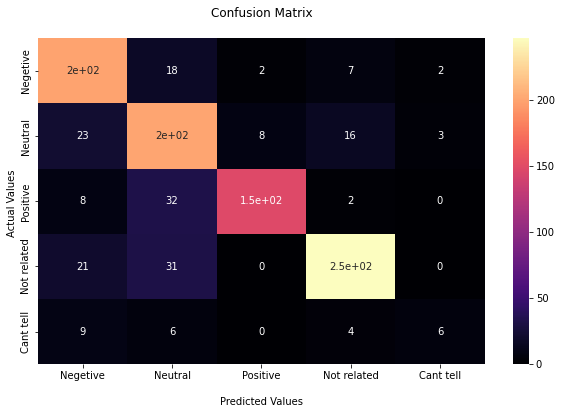

In [31]:
plt.figure(figsize=(10,6))
ax = sns.heatmap(Confusion_matrix, annot=True, cmap = plt.cm.magma)

ax.set_title('Confusion Matrix\n');
ax.set_xlabel('\nPredicted Values')
ax.set_ylabel('Actual Values ');

ax.xaxis.set_ticklabels(i for i in ('Negetive', 'Neutral', 'Positive', 'Not related', 'Cant tell'))
ax.yaxis.set_ticklabels(i for i in ('Negetive', 'Neutral', 'Positive', 'Not related', 'Cant tell'))
plt.show()